In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using Plots, QuadGK
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

In [3]:
using ChainRulesCore: ignore_derivatives

In [4]:
using Base: @kwdef

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
size(q)

(20, 13, 21, 99991)

In [12]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [13]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [14]:
q |> size

(20, 13, 21, 99991)

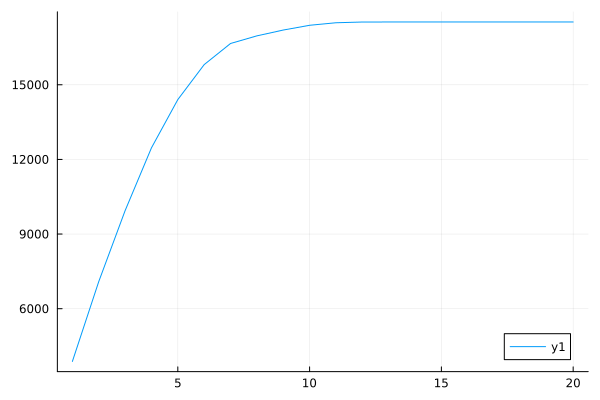

In [15]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

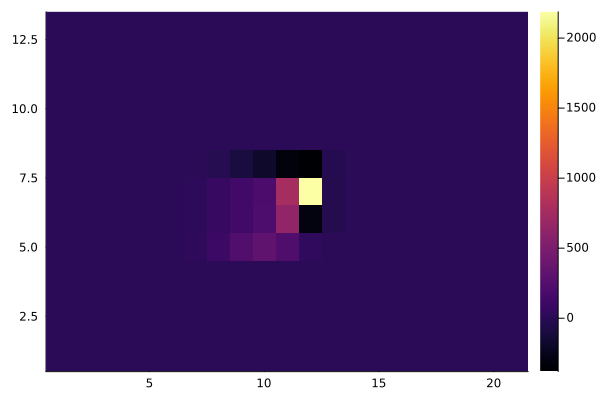

In [16]:
heatmap(q[1,:,:,128])

In [17]:
x = q[:,:,:,1:128]
xl = ylocal[1:128]
y = pt[1:128];

In [18]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [19]:
x |> size

(20, 13, 21, 128)

In [20]:
n_px = size(x, 2) 
n_in = n_px + 1

14

In [397]:
spk_args = SpikingArgs(threshold=1e-5, leakage=-0.2)
tspan = (0.0, 5.0)

(0.0, 5.0)

# Drive currents into Phases

In [22]:
x_tms = range(start=0.0, stop=1.0, length=size(x,1)) |> collect;

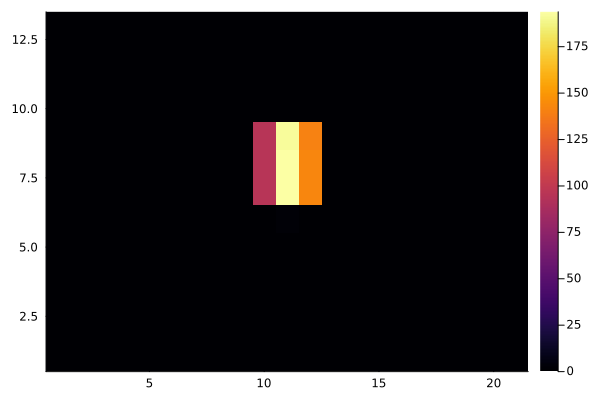

In [23]:
heatmap(interpolate_2D_derivative(0.5, x_tms, x)[:,:,1])

In [24]:
xi = charge_to_current(x, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.

In [25]:
xi.current.shape

(13, 128)

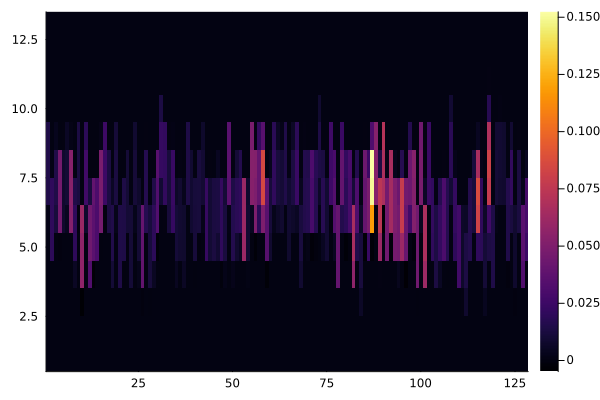

In [26]:
heatmap(xi.current.current_fn(0.4))

In [27]:
xli = ylocal_to_current(xl, spk_args=spk_args, tspan=tspan)

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, (0.0, 5.0))

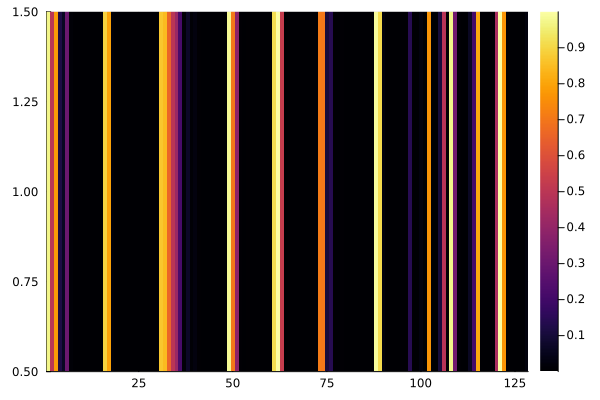

In [28]:
heatmap(xli.current.current_fn(0.7))

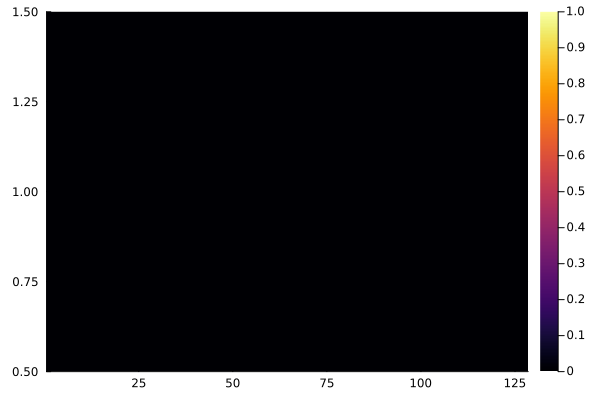

In [29]:
heatmap(xli.current.current_fn(1.7))

In [30]:
xli

CurrentCall(LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, (0.0, 5.0))

In [31]:
xli.t_span

(0.0, 5.0)

In [32]:
xi.current.shape

(13, 128)

In [33]:
xxli = cat_currents(xi, xli, dim=1)

CurrentCall(LocalCurrent(var"#34#36"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

In [34]:
xxli.current.shape

(14, 128)

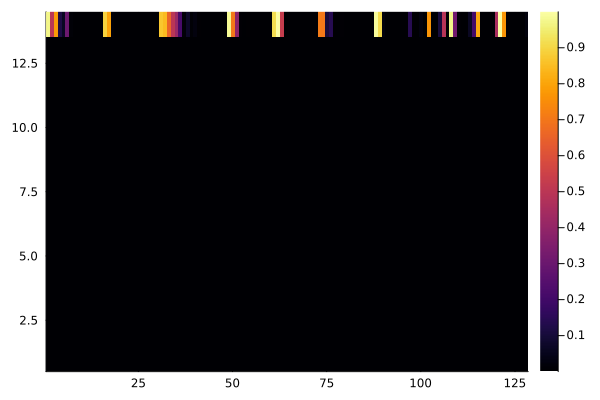

In [35]:
heatmap(xxli.current.current_fn(0.7))

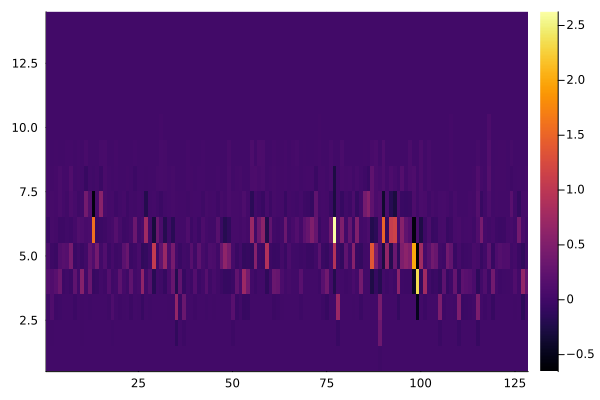

In [36]:
heatmap(xxli.current.current_fn(0.3))

In [37]:
stats_sample = [vec(xxli.current.current_fn(t)) for t in 0.0:0.05:1.25] |> stack;

In [38]:
extrema(stats_sample)

(-0.9585047619047619, 4.74392)

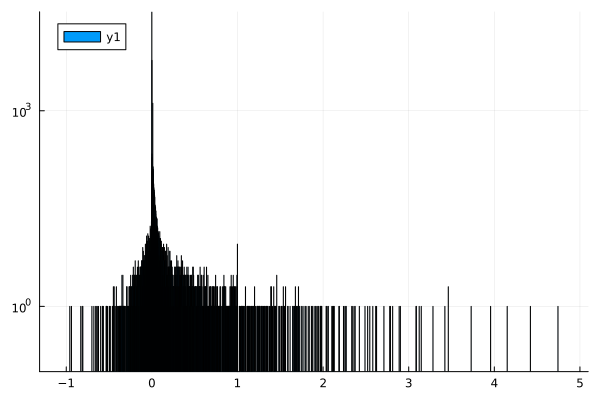

In [39]:
histogram(vec(stats_sample), yscale=:log10)

In [40]:
x1 = process_sample((x, xl), spk_args=spk_args, tspan=tspan, clock_amp=0.01)

CurrentCall(LocalCurrent(var"#34#36"{Int64, LocalCurrent, LocalCurrent}(1, LocalCurrent(PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.39321476923076926 0.4332816923076923 … 0.5020666461538461 0.4779598461538462]), (1, 128), 0.0), LocalCurrent(var"#28#30"{Float64, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}, var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}}(0.01, PhasorNetworks.var"#inner#85"{SpikingArgs, Float64, Bool, Vector{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, 0.0, false, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), var"#current_fn#29"{Array{Float64, 4}, Vector{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

In [41]:
ode_front = Chain(PhasorResonant(n_in, spk_args),)

PhasorResonant(14, PhasorNetworks.var"#170#172"{Int64}(14), true, true)

## Setup the Resonating Layer

In [44]:
function data_to_phase(q, yl; spk_args::SpikingArgs, tspan::Tuple, clock_amp::Real = 0.01)
    x = process_sample((q, yl), spk_args=spk_args, tspan=tspan, clock_amp=clock_amp)
    ode_front = Chain(PhasorResonant(n_in, spk_args),)

    rng = Xoshiro(42)
    ps_ode, st_ode = Lux.setup(rng, ode_front)
    sol = ode_front(x, ps_ode, st_ode)[1]
    mp = mean_phase(sol, 1, spk_args=spk_args, offset=0.0, threshold=false)
    train = solution_to_train(sol, tspan, spk_args=spk_args, offset=0.0)

    return mp, train
end

data_to_phase (generic function with 1 method)

In [45]:
x_mp, _ = data_to_phase(q, ylocal, spk_args=spk_args, tspan=tspan, clock_amp=0.01)

([-0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; -0.0032434995223176236 -0.021758589366079384 … -0.0032434995223176236 -0.0032434995223176236; … ; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; 0.39023024884644497 0.43032350947863374 … 0.5260822059769902 0.48554924035638264], Spike Train: (14, 99991) with 6999330 spikes.)

In [89]:
train_loader = DataLoader((x_mp, pt), partial = false, batchsize=args.batchsize)

781-element DataLoader(::Tuple{Matrix{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (14×128 Matrix{Float64}, 128-element Vector{Float64},)

# Setup the Classifying Model

In [50]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [51]:
ode_model = Chain(
                PhasorDenseF32(n_in => 128),
                PhasorDenseF32(128 => 3)
                )

Chain(
    layer_1 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_2 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_438 parameters,
          #        plus 0 states.

In [52]:
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [53]:
x1 = first(train_loader)

([-0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; -0.0032434995223176236 -0.021758589366079384 … -0.004050993019657057 -0.0032434995223176236; … ; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; 0.39023024884644497 0.43032350947863374 … 0.4991537613301872 0.47503117133691647], [0.656019, 0.637776, -1.54754, 0.46886, 0.555289, -0.438797, 0.740845, 0.544609, -0.727205, -0.941404  …  0.817292, 0.540987, 1.22233, -0.523964, -0.889413, 2.83394, 0.587626, -0.874592, -0.698757, -0.555948])

In [55]:
y_naive, _ = ode_model(x1[1], ps, st);

In [56]:
y_naive

3×128 Matrix{Float64}:
  0.893394    0.56974     0.705945    …   0.682188   0.660822    0.538057
 -0.927143    0.959371    0.991794        0.982034   0.917096   -0.993742
 -0.0116426  -0.0400601  -0.00740478     -0.016455  -0.0401018  -0.0426615

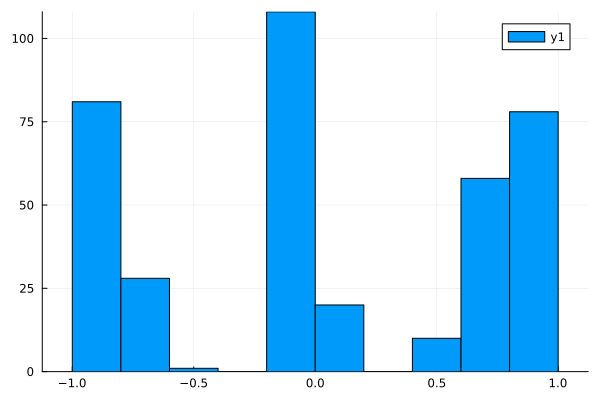

In [57]:
histogram(y_naive |> vec, bins=10)

In [58]:
psf = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [59]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [60]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [61]:
function loss(x, y, model, ps, st, threshold)
    y_pred, st = model(x, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [64]:
loss(x1[1], x1[2], ode_model, psf, st, 0.2)

(1.272549048396147, (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [63]:
v, gs = withgradient(p -> loss(x1[1], x1[2], ode_model, p, st, 0.2), psf)

(val = (1.272549048396147, (layer_1 = NamedTuple(), layer_2 = NamedTuple())), grad = ((layer_1 = (weight = Float32[-0.0020641573 -0.0015332886 … -0.002110413 -0.0038708684; -0.003553751 -0.005791161 … -0.0033504588 0.042427458; … ; 0.0029688133 0.0030376099 … 0.002907561 0.007842983; -0.0117901955 -0.009494617 … -0.011798134 -0.044192784], bias_real = Float32[-0.0021569876, -0.0029109896, 0.00506592, -0.03653563, 0.009793149, 0.0070718285, -0.0064251525, -0.013313776, 0.0008936532, 0.050148338  …  0.004926753, -0.09213726, -0.005354397, 0.00038913594, 0.010458433, -0.0018503306, -0.00016223095, -0.0017774064, 0.0029879918, -0.0122830095], bias_imag = Float32[-0.0045598173, 0.043144125, 0.017141808, -0.031086644, -0.03608597, -0.010732363, -0.01653804, -0.054725073, 0.013500536, 0.021243356  …  0.030465262, 0.16997492, -0.015218942, -0.0064597707, -0.04127732, -0.008491279, -0.029105388, 0.033543207, 0.00787822, -0.047522843]), layer_2 = (weight = Float32[-0.68578726 -0.66723543 … -0.67

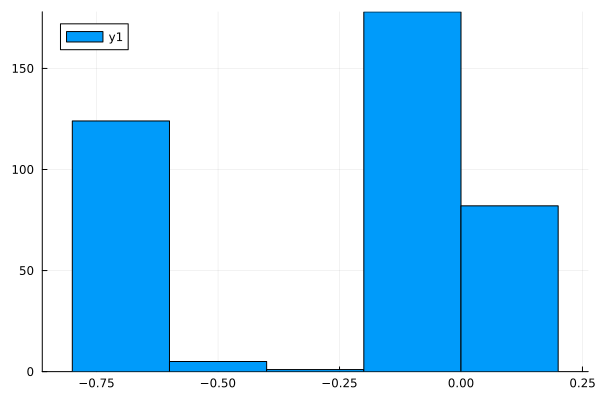

In [65]:
histogram(vec(gs[1].layer_2))

In [69]:
function train(model, ps, st, train_loader; threshold::Real = 0.2, id::Int=1, verbose::Bool = true, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            if verbose
                println(reduce(*, ("Epoch ", string(epoch), ", loss ", string(loss_val))))
            end
        end
        append!(losses, epoch_losses)
        println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 1 method)

In [70]:
loss_history, pst, stt = train(ode_model, psf, st, train_loader, threshold = 0.2, epochs = 10, verbose=false);

Epoch 1

[ Info: Constructing model and starting training


 mean loss 0.2257670825651392
Epoch 2 mean loss 0.19909175953388775
Epoch 3 mean loss 0.1821007005234866
Epoch 4 mean loss 0.16827679296201709
Epoch 5 mean loss 0.16363733067124764
Epoch 6 mean loss 0.16170689647379058
Epoch 7 mean loss 0.1600510176259119
Epoch 8 mean loss 0.16160250936701695
Epoch 9 mean loss 0.15817752091718856
Epoch 10 mean loss 0.15759315365200305


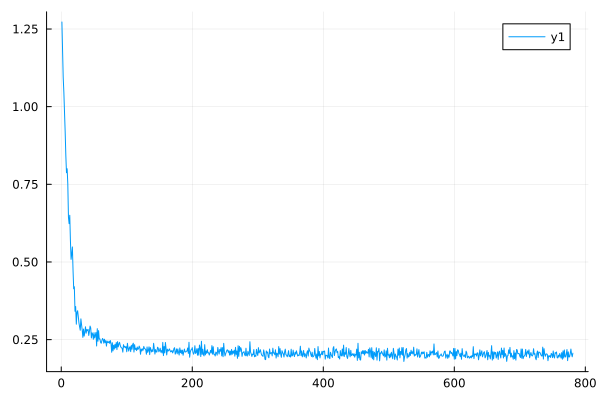

In [213]:
plot(loss_history)

In [71]:
#loss_history2, pst2, stt2 = train(ode_model, pst, st, train_loader, threshold = 0.2, epochs = 10)

In [72]:
#plot(append!(loss_history, loss_history2))

In [73]:
loss_history[end]

0.18034146619115574

In [74]:
#load params

In [75]:
#res = load("trained_nns/ode_id_43_epoch_100.jld2")

In [76]:
# pst = res["params"]
# stt = res["state"]

In [77]:
pst2 = pst

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.02801542 0.10101216 … -0.004794595 -0.10292167; -0.13578202 0.0045885737 … 0.08933807 -0.17331582; … ; 0.1617685 -0.21800296 … -0.091009885 -0.1541594; 0.117790714 -0.057199027 … 0.14964096 -0.15731345], bias_real = Float32[0.9991786, 0.96704674, 0.9930356, 0.93876535, 0.9835317, 0.92716235, 0.97823066, 0.9365955, 0.9481042, 1.0561672  …  1.0653288, 1.1116146, 0.9889288, 0.928033, 0.9725309, 0.9702435, 1.0563186, 0.88683075, 1.0009482, 1.1033895], bias_imag = Float32[0.049730677, -0.03648769, 0.046352904, -0.046995647, 0.05640096, -0.08347357, -0.006783062, 0.0007696016, 0.0005787975, 0.029135838  …  -0.010881768, -0.042908523, 0.021360403, 0.042533655, 0.031776756, 0.07868608, 0.009934804, -0.033725675, -0.05200921, 0.05618783]), layer_2 = (weight = Float32[0.1312479 0.08910861 … -0.018954143 0.0841492; -0.0171045 -0.14537363 … 0.06148461 0.043920718; 0.016035445 -0.18732736 … -0.16057688 0.25442883], bias_real = Float32[1.028312

In [79]:
loss(x1[1], x1[2], ode_model, pst2, stt, 0.2)

(0.15562285953468452, (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [80]:
yt, _ = ode_model(x1[1], pst2, stt)

([0.02156601420277869 0.018091602516835895 … 0.011526187799959313 0.022161138638058613; 0.38144939554946167 0.19144865722493015 … -0.0008195497489075292 0.26823127834259763; 0.07574524934996596 0.305065461784215 … 0.4060551342656316 -0.00967541046105935], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

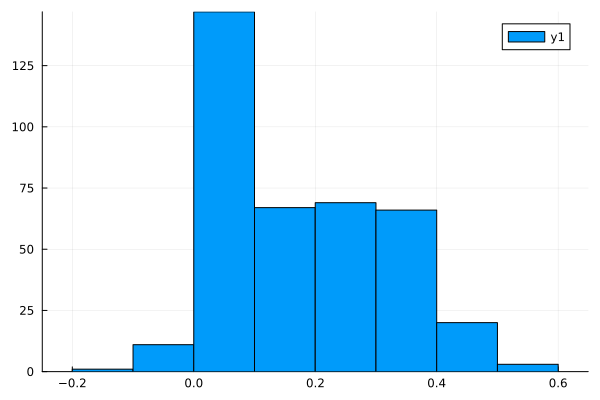

In [81]:
histogram(yt |> vec)

In [82]:
using JLD2

In [149]:
#trained = load_object("trained_resonant.jld2")

In [150]:
#pst2 = trained["params"]
#stt = trained["state"]

In [226]:
save_object("trained_resonant.jld2", Dict("params" => pst2, "state" => stt))

In [251]:
save_object("data/train_phase.jld2", Dict("phase" => x_mp, "momentum" => pt))

# Calculate the Test Loss

In [83]:
test_mp, test_train = data_to_phase(q_test, ylocal_test, spk_args=spk_args, tspan=tspan)

([-0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 0.7207726849204222; … ; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; 0.3958040615138273 0.490235905683496 … 0.4044108269480027 0.5210426807938952], Spike Train: (14, 49998) with 3499842 spikes.)

In [265]:
save_object("data/test_phase.jld2", Dict("phase" => test_mp, "momentum" => pt_test, "spikes" => test_train))

In [88]:
test_loader = DataLoader((test_mp, pt_test), partial = false, batchsize=args.batchsize)

390-element DataLoader(::Tuple{Matrix{Float64}, Vector{Float64}}, batchsize=128, partial=false)
  with first element:
  (14×128 Matrix{Float64}, 128-element Vector{Float64},)

In [90]:
xts, yts = first(test_loader)

([-0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.3877932705989078; … ; -0.0032434995223176236 -0.0032434995223176236 … -0.0032434995223176236 -0.0032434995223176236; 0.3958040615138273 0.490235905683496 … 0.46585030531307026 0.4459309630035237], [-0.186883, -0.261643, 0.442997, -0.228423, 0.249504, -0.2267, 0.23921, 0.24106, -0.186514, -0.176539  …  0.866878, -0.379843, -0.321384, -1.15701, -0.660461, 0.814443, -1.28697, 0.619098, 0.392916, 0.621342])

In [91]:
function accuracy(x, y, model_call::Function, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred = model_call(x)
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 2 methods)

In [92]:
accuracy(xts, yts, x -> ode_model(x, pst2, stt)[1], 0.2)

91

In [94]:
xts

14×128 Matrix{Float64}:
 -0.0032435  -0.0032435   -0.0032435  …  -0.0034346  -0.0032435  -0.0032435
 -0.0032435  -0.0032435   -0.0032435     -0.947331   -0.0032435  -0.387793
 -0.0084937  -0.0032435   -0.0032435     -0.535731   -0.940653   -0.620129
 -0.845676   -0.956732    -0.952449      -0.684735   -0.556591   -0.61765
 -0.578681   -0.562991    -0.592112      -0.841371   -0.680897   -0.784945
 -0.770226   -0.766038    -0.586499   …  -0.919638   -0.855371   -0.904422
 -0.909968    0.589314    -0.770811      -0.241077   -0.878095   -0.55178
 -0.132939   -0.221929    -0.935522      -0.695585   -0.430654   -0.611355
 -0.711453   -0.00471644  -0.126871      -0.0032435  -0.0625148  -0.0032435
 -0.0032435  -0.0032435   -0.820189      -0.0032435  -0.0032435  -0.0032435
 -0.0032435  -0.0032435   -0.0032435  …  -0.0032435  -0.0032435  -0.0032435
 -0.0032435  -0.0032435   -0.0032435     -0.0032435  -0.0032435  -0.0032435
 -0.0032435  -0.0032435   -0.0032435     -0.0032435  -0.0032435  -0.00324

In [95]:
test_mp |> size

(14, 49998)

In [96]:
@time yth = ode_model(test_mp[:,1:10000], pst2, stt)[1]

  0.629767 seconds (5.03 k allocations: 103.890 MiB, 90.33% gc time, 0.74% compilation time)


3×10000 Matrix{Float64}:
 0.0112882  0.0134526  0.0154199  …  0.0119515  0.0293069   0.0128898
 0.0312107  0.0582782  0.242752      0.188791   0.00928771  0.120836
 0.445735   0.445635   0.213052      0.247986   0.405686    0.354099

In [99]:
@time yth = ode_model(test_mp, pst2, stt)[1]

  0.905576 seconds (35 allocations: 512.330 MiB, 76.58% gc time)


3×49998 Matrix{Float64}:
 0.0112882  0.0134526  0.0154199  …  0.0121268  0.0160099  0.0306972
 0.0312107  0.0582782  0.242752      0.193015   0.147137   0.498497
 0.445735   0.445635   0.213052      0.410427   0.461125   0.264176

In [100]:
function accuracy_compare(y_pred, y, threshold::Real)
    y_labels = predict_quadrature(y_pred) .- 1
    y_truth = get_truth(y, threshold)
    right = sum(y_truth .== y_labels)
    return right
end

accuracy_compare (generic function with 1 method)

In [101]:
accuracy_compare(yth, pt_test, 0.2)

36212

In [102]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [103]:
using LinearAlgebra: diag

In [105]:
roc = tpr_fpr(yth, pt_test)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [106]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

27-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 2.4097349436146124e-7
 3.000120004800192e-5
 0.00016000640025601025
 0.0005800232009280372
 0.0034001360054402175
 0.017640705628225128
 0.0640425617024681
 0.1688467538701548
 0.33831353254130164
 0.5357214288571542
 0.7060282411296452
 0.8224328973158926
 0.8879755190207609
 ⋮
 0.9911196447857914
 0.9953998159926397
 0.9970598823952959
 0.9982599303972158
 0.9987999519980799
 0.999339973598944
 0.999619984799392
 0.999819992799712
 0.999919996799872
 0.999979999199968
 1.0
 1.0

In [107]:
roc_xs = 0.0:0.01:1.0

0.0:0.01:1.0

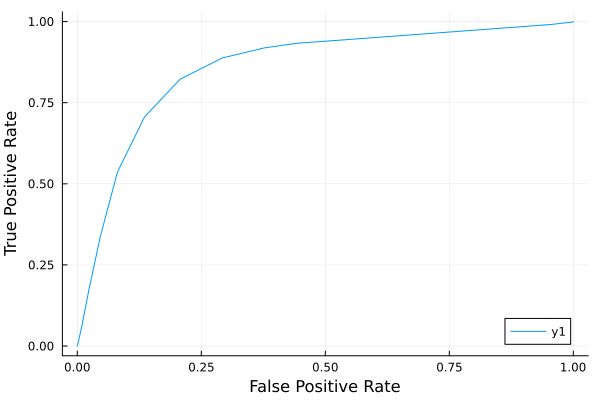

In [108]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

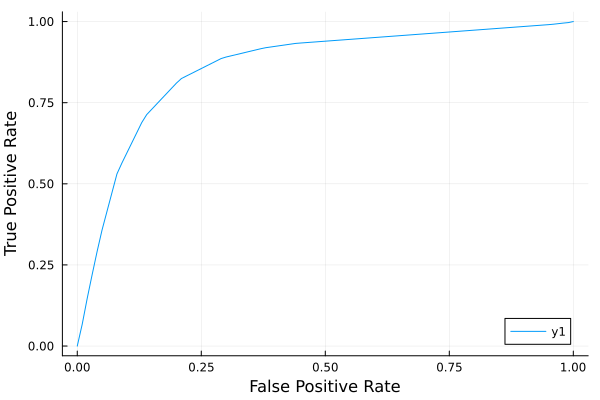

In [109]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [110]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8592467923320954, 1.2498955513568365e-8)

# Make a spiking version

In [534]:
tspan_exec = (0.0, 30.0)
spk_args_exec = SpikingArgs(solver=Tsit5(), leakage=-0.2)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [535]:
@time test_mp, test_train = data_to_phase(q_test[:,:,:,1:1000], ylocal_test[1:1000], spk_args=spk_args, tspan=tspan_exec)

 13.690460 seconds (692.41 k allocations: 38.438 GiB, 64.25% gc time)


([-0.01969452739180595 -0.01969452739180595 … -0.01969452739180595 -0.01969452739180595; -0.01969452739180595 -0.01969452739180595 … -0.01969452739180595 -0.01969452739180595; … ; -0.01969452739180595 -0.01969452739180595 … -0.01969452739180595 -0.01969452739180595; 0.3793533020462249 0.47378520094443183 … 0.5358253864928313 0.5789787705165829], Spike Train: (14, 1000) with 325632 spikes.)

In [536]:
#phase from the spike train 
ptrain = train_to_phase(test_train, spk_args=spk_args_exec);

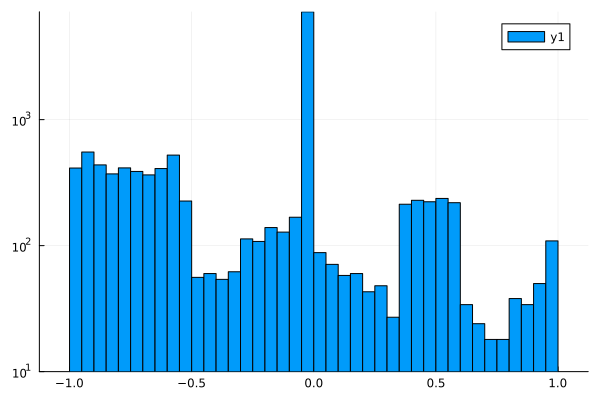

In [537]:
histogram(test_mp |> vec, yscale=:log10)

In [538]:
#correlation between the mean phase and spike train (basically perfect)
cycle_correlation(test_mp[:,1:1000], ptrain)

30-element Vector{Float64}:
 0.9560589128969154
 0.9584197437058759
 0.9623528304309668
 0.9662837629868996
 0.9686413595001011
 0.9694202150493207
 0.9756954639424609
 0.9764694774814723
 0.9803838353181159
 0.9827276579952522
 0.9835013839461115
 0.9874198712478862
 0.9897630728259779
 ⋮
 0.9887066146658208
 0.9849044236298606
 0.9800596581737611
 0.9761610525251677
 0.9683528213679407
 0.9595122492355551
 0.9561694519773939
 0.9497084495185675
 0.9470368511121465
 0.9451286537374741
 0.942160364116079
 0.9409647935085174

In [539]:
#directly test driving the network by exact phase values
test_phase = phase_to_train(test_mp, spk_args=spk_args_exec, repeats=20, offset=0.25)

Spike Train: (14, 1000) with 280000 spikes.

In [540]:
test_subset = test_train

Spike Train: (14, 1000) with 325632 spikes.

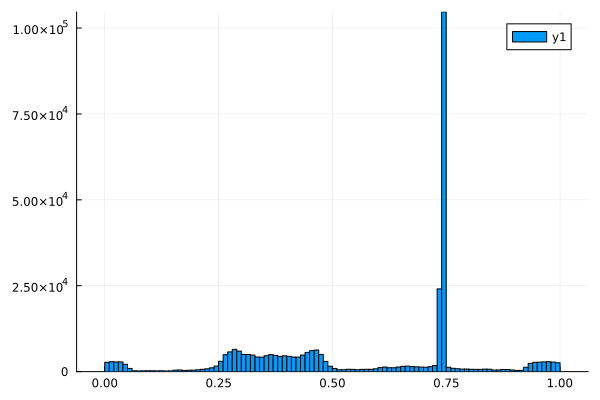

In [541]:
histogram(mod.(test_subset.times, 1.0))

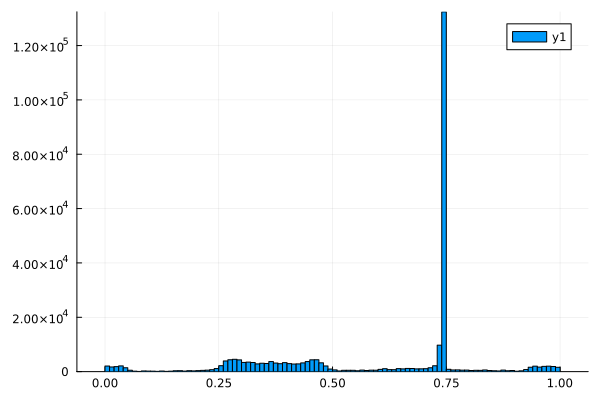

In [542]:
histogram(mod.(test_phase.times, 1.0))

In [543]:
test_call = SpikingCall(test_subset, spk_args_exec, tspan_exec)

SpikingCall(Spike Train: (14, 1000) with 325632 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 30.0))

In [544]:
test_call_phase = SpikingCall(test_phase, spk_args_exec, tspan_exec)

SpikingCall(Spike Train: (14, 1000) with 280000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 30.0))

In [545]:
yspk, _ = ode_model(test_call, pst2, stt)

(SpikingCall(Spike Train: (3, 1000) with 89996 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 30.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [546]:
yspk2, _ = ode_model(test_call_phase, pst2, stt)

(SpikingCall(Spike Train: (3, 1000) with 89988 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 30.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [547]:
ode_baby = Chain(
                PhasorDenseF32(n_in => 128),
                )

PhasorDenseF32((14, 128))  # 2_048 parameters

In [548]:
ps_baby = pst2.layer_1;

In [549]:
st_baby = st.layer_1;

In [550]:
y_baby_p, _ = ode_baby(test_mp[:,1:1000], ps_baby, st_baby);

In [551]:
y_baby, _ = ode_baby(test_call, ps_baby, st_baby)

(SpikingCall(Spike Train: (128, 1000) with 3839975 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 30.0)), NamedTuple())

In [552]:
y_baby_direct, _ = ode_baby(test_call2, ps_baby, st_baby)

(SpikingCall(Spike Train: (128, 1000) with 2560000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 1.0e-5 (V)
, (0.0, 20.0)), NamedTuple())

In [553]:
y_baby_spk = train_to_phase(y_baby);

In [554]:
y_baby_direct_p = train_to_phase(y_baby_direct);

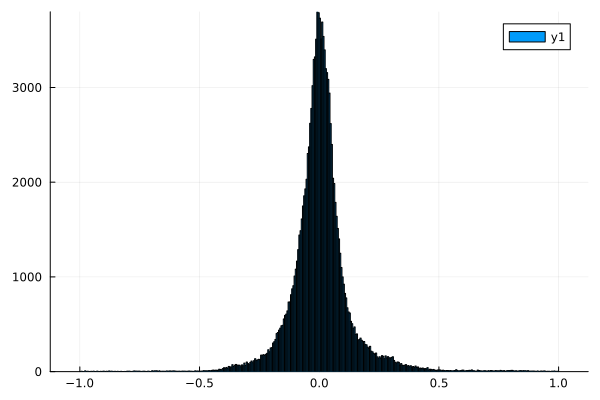

In [555]:
histogram(vec(y_baby_p))

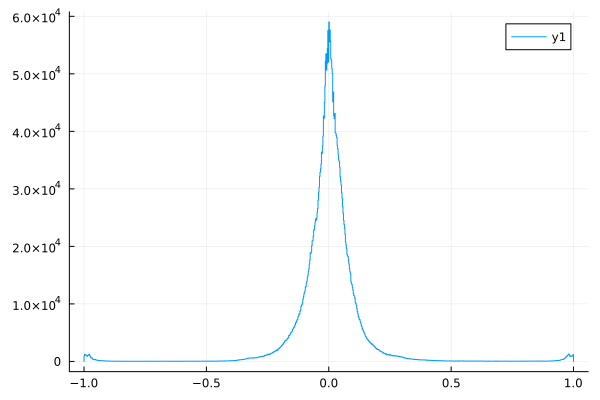

In [556]:
histogram(vec(y_baby_spk))

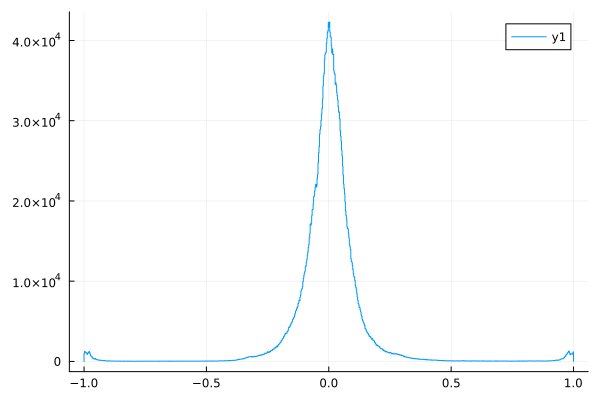

In [557]:
histogram(vec(y_baby_spk[5:end,:,:]))

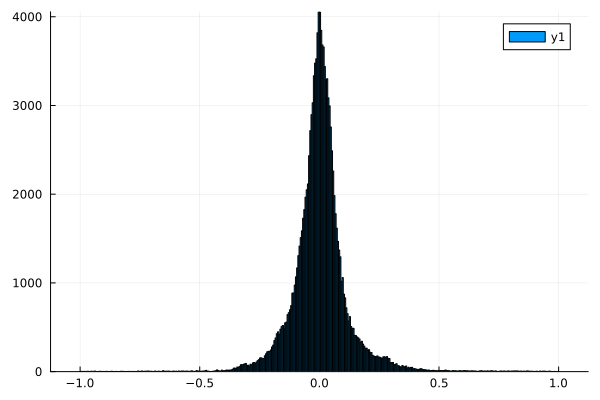

In [558]:
histogram(vec(y_baby_spk[10,:,:]))

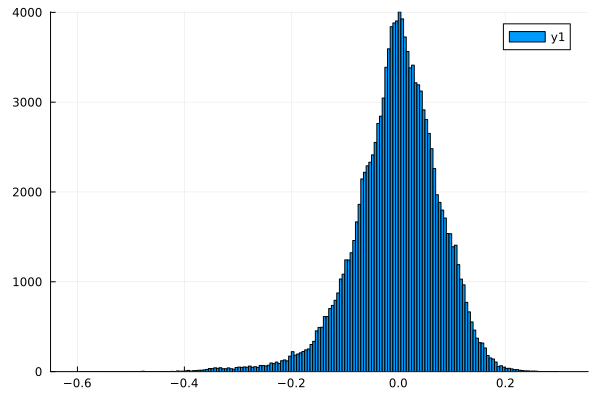

In [559]:
histogram(vec(y_baby_spk[end-5,:,:]))

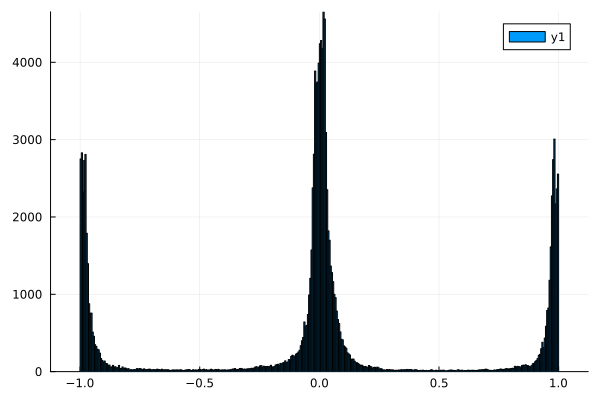

In [560]:
histogram(vec(y_baby_spk[end,:,:]))

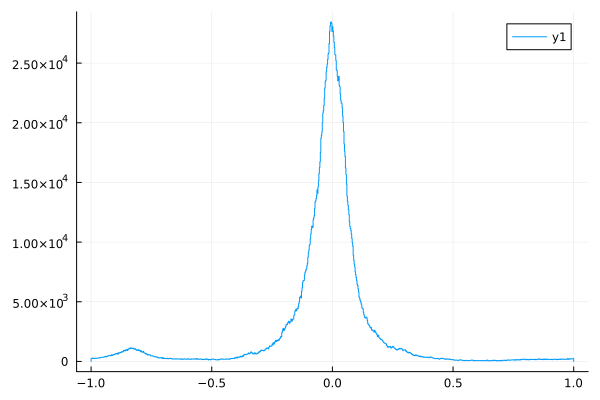

In [561]:
histogram(vec(y_baby_direct_p))

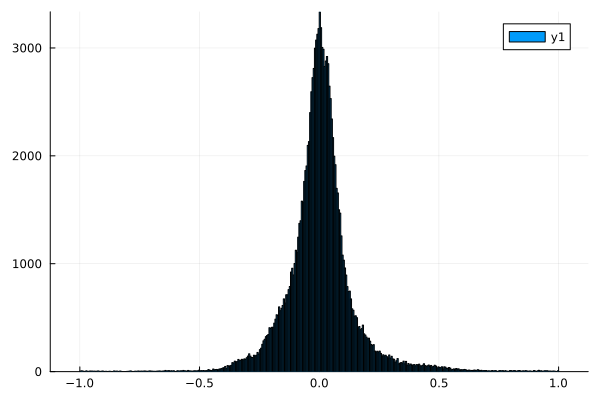

In [562]:
histogram(vec(y_baby_direct_p[1,:,:]))

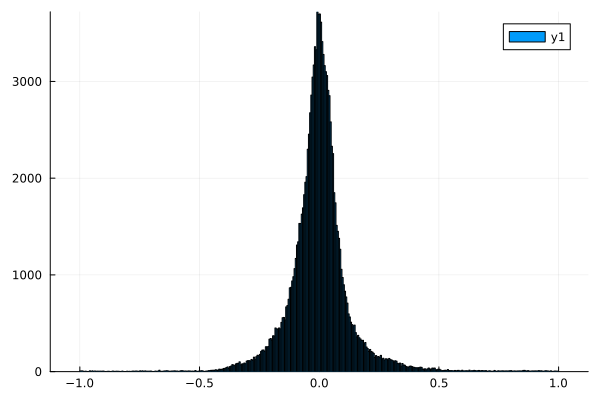

In [563]:
histogram(vec(y_baby_direct_p[5,:,:]))

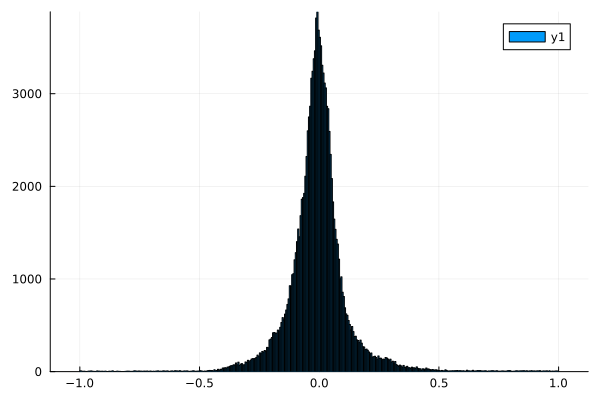

In [564]:
histogram(vec(y_baby_direct_p[end-1,:,:]))

In [565]:
size(y_baby_p)

(128, 1000)

In [566]:
size(y_baby_spk)

(30, 128, 1000)

In [567]:
spk_args.solver

Heun(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)

In [568]:
spk_args.solver_args

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

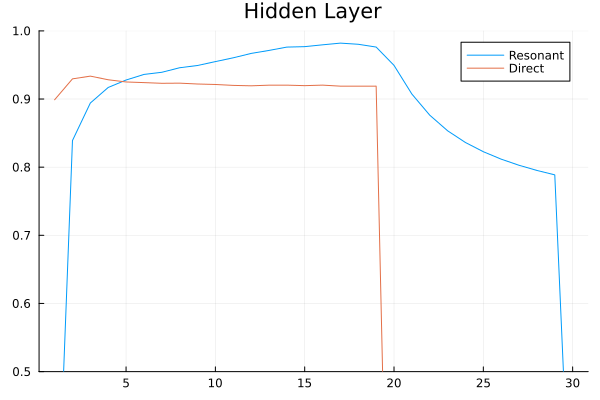

In [569]:
plot(cycle_correlation(y_baby_p, y_baby_spk), label="Resonant")
plot!(cycle_correlation(y_baby_p, y_baby_direct_p), label="Direct")
ylims!(0.50, 1.0)
title!("Hidden Layer")

In [570]:
yspk_p = train_to_phase(yspk);

In [571]:
size(yth[:,1:1000])

(3, 1000)

In [572]:
size(yspk_p)

(30, 3, 1000)

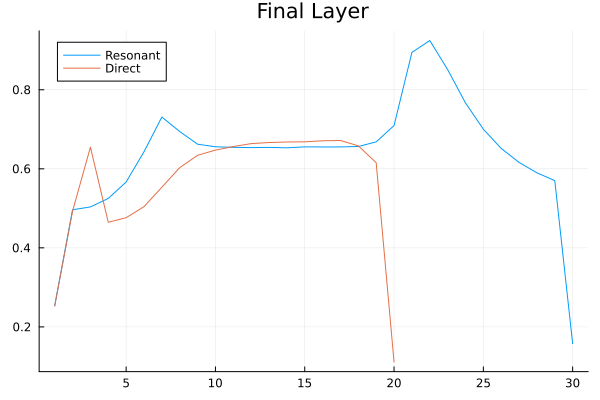

In [573]:
plot(cycle_correlation(yth[:,1:1000], yspk_p), label="Resonant")
plot!(cycle_correlation(yth[:,1:1000], yspk_p2), label="Direct")
title!("Final Layer")

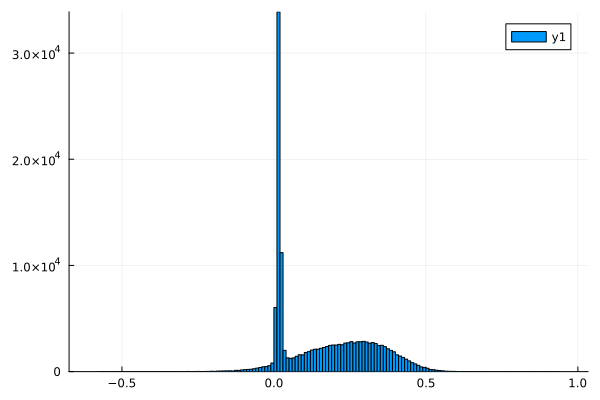

In [574]:
histogram(vec(yth))

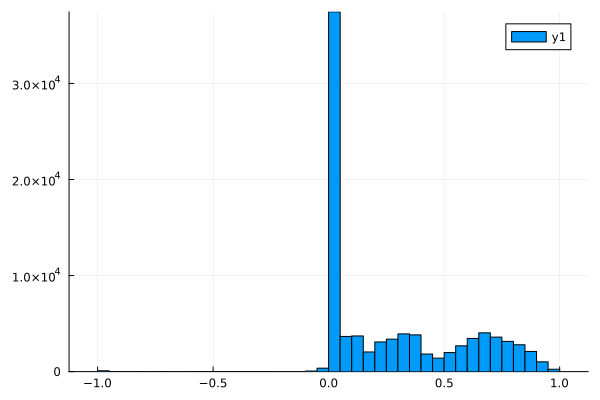

In [575]:
histogram(vec(yspk_p))

In [576]:
yspk_p2 = train_to_phase(yspk2);

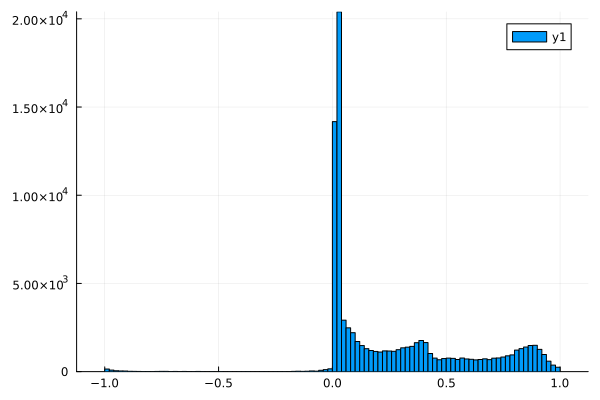

In [577]:
histogram(vec(yspk_p2))

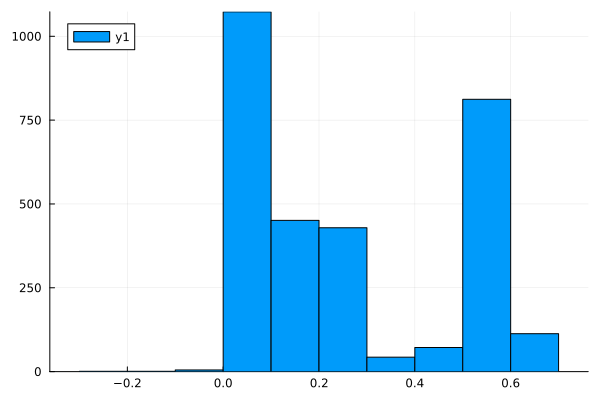

In [578]:
histogram(vec(yspk_p[6,:,:]))

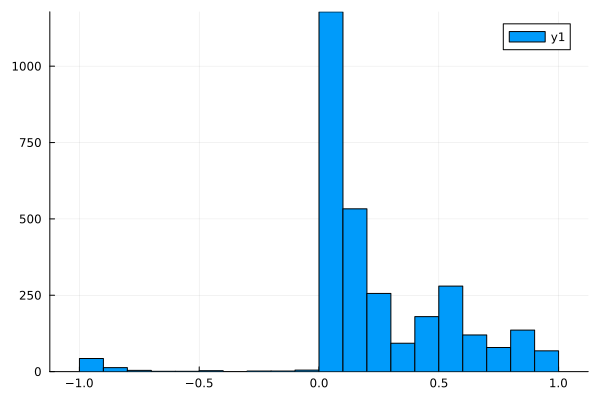

In [579]:
histogram(vec(yspk_p2[5,:,:]))

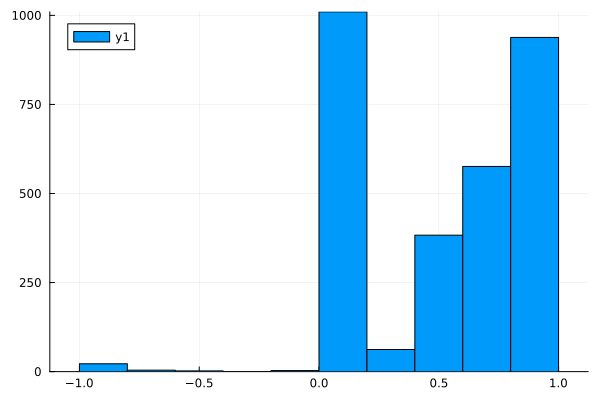

In [580]:
histogram(vec(yspk_p2[15,:,:]))

In [581]:
size(yspk_p)

(30, 3, 1000)

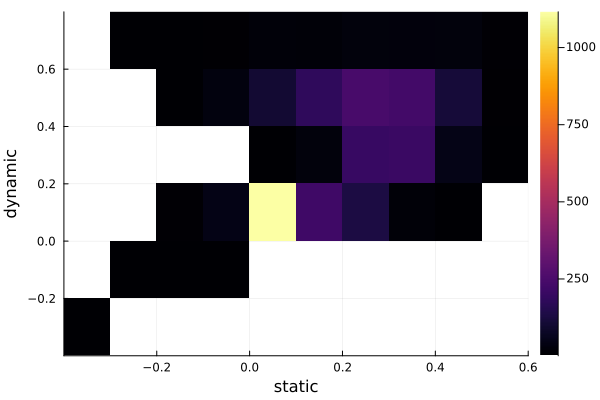

In [582]:
histogram2d(yth[:,1:1000] |> vec, yspk_p[6,:,:] |> vec)
xlabel!("static")
ylabel!("dynamic")

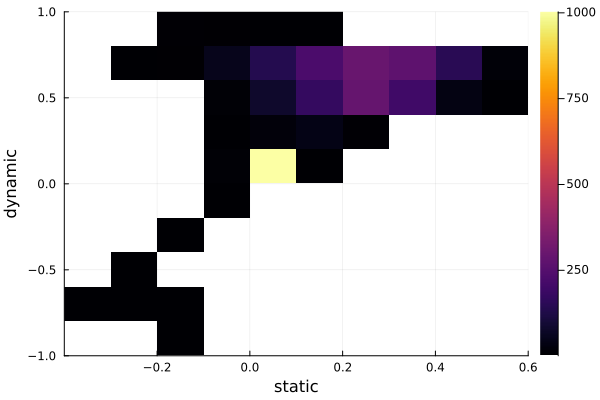

In [583]:
histogram2d(yth[:,1:1000] |> vec, yspk_p[8,:,:] |> vec)
xlabel!("static")
ylabel!("dynamic")

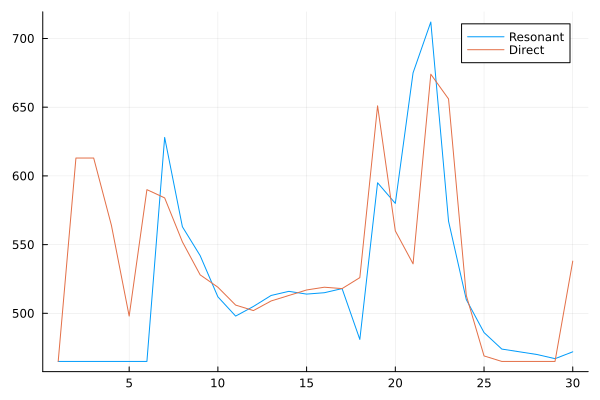

In [584]:
plot([accuracy_compare(aa, pt_test[1:1000], 0.2) for aa in eachslice(yspk_p, dims=1)], label="Resonant")
plot!([accuracy_compare(aa, pt_test[1:1000], 0.2) for aa in eachslice(yspk_p2, dims=1)], label="Direct")

In [585]:
function calc_auroc(yh)
    roc_spk = tpr_fpr(yh, pt_test[1:1000])
    roc_fn_spk = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...);
    auc, _ = quadgk(roc_fn_spk, 0.0, 1.0)
    return auc
end

calc_auroc (generic function with 1 method)

In [587]:
map(calc_auroc, eachslice(yspk_p, dims=1))

30-element Vector{Float64}:
 0.5
 0.5987499997353385
 0.6222413325673242
 0.7227125857940002
 0.7375742688742333
 0.7367471106431909
 0.7335636179733876
 0.6880306835536073
 0.6754762373965243
 0.6774843937878077
 0.6783446263450017
 0.6785993331534733
 0.6760691690416156
 ⋮
 0.7423518026704101
 0.7744660318931577
 0.8408849949654277
 0.8438765022024028
 0.7978841487659682
 0.7754309882440645
 0.7612954975790269
 0.752369748157282
 0.7405907497625664
 0.7306840041199051
 0.7214724841689526
 0.5

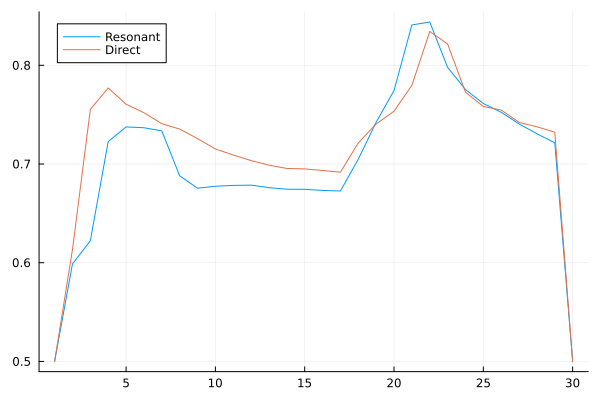

In [586]:
plot(map(calc_auroc, eachslice(yspk_p, dims=1)), label="Resonant")
plot!(map(calc_auroc, eachslice(yspk_p2, dims=1)), label="Direct")